In [1]:
print_version = lambda m: print("{:10}: {:12}".format(m.__name__, m.__version__))

import kagglehub

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import (
#     classification_report,
#     confusion_matrix,
#     roc_curve,
#     roc_auc_score,
#     auc,
#     accuracy_score,
#     f1_score,
#     precision_score,
#     recall_score,
# )

from pathlib import Path


print_version(np)
print_version(pd)
print_version(sns)
print_version(matplotlib)

numpy     : 1.26.4      
pandas    : 2.1.4       
seaborn   : 0.13.1      
matplotlib: 3.9.2       


In [2]:
# Словарь с названиями аттрибутов
features_dict = dict(
    hoursweek='Занятий в неделю',
    attendance_rate='Посещаемость',
    previous_grades='Успеваемость',
    extracurricular_activities='Участие во внеклассных мероприятиях',
    parent_education_level='Уровень образования родителей'
)

In [3]:
# загрузка данных с kagglehub
path = kagglehub.dataset_download("souradippal/student-performance-prediction")
print("Path to dataset files:", path)

100%|██████████| 381k/381k [00:00<00:00, 16.3MB/s]

Extracting files...
Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/souradippal/student-performance-prediction/versions/1


## Структура датасета

* `Student ID`: Идентификатор студента
* `Study Hours per Week`: Занятий в неделю (Час)
* `Attendance Rate`: Посещаемость занятий (%)
* `Previous Grades`: Успеваемость, средний бал (0 до 100 баллов)
* `Participation in Extracurricular Activities`: Участие во внеклассных мероприятиях (Да/Нет)
* `Parent Education Level`: Уровень образования родителей (По словарю)
* `Passed`: показатель окончания студентом обучения (Да/Нет)

### Значения поля `Parent Education Level`
* `Associate`: Базовая степень (usa)
* `High School`: Высшее образование
* `Bachelor`: Бакалавр
* `Master`: Магистр
* `Doctorate`: Доктор

In [4]:
# загрузка файла, установка заголовков
df = pd.read_csv(path + '/student_performance_prediction.csv')
df.columns = ["studentid", "hoursweek", "attendance_rate", "previous_grades", "extracurricular_activities", "parent_education_level", "passed"]

print(df.shape)
df.head()

(40000, 7)


,studentid,hoursweek,attendance_rate,previous_grades,extracurricular_activities,parent_education_level,passed
0,S00001,12.5,NaN,75.0,Yes,Master,Yes
1,S00002,9.3,95.3,60.6,No,High School,No
2,S00003,13.2,NaN,64.0,No,Associate,No
3,S00004,17.6,76.8,62.4,Yes,Bachelor,No
4,S00005,8.8,89.3,72.7,No,Master,No


In [5]:
df.describe(include='all')

,studentid,hoursweek,attendance_rate,previous_grades,extracurricular_activities,parent_education_level,passed
count,40000,38005.000000,38008.000000,38006.000000,38000,38000,38000
unique,40000,NaN,NaN,NaN,2,5,2
top,S00001,NaN,NaN,NaN,No,Bachelor,Yes
freq,1,NaN,NaN,NaN,19028,7685,19011
mean,NaN,9.962744,75.276323,65.440107,NaN,NaN,NaN
std,NaN,5.031154,20.393418,16.503119,NaN,NaN,NaN
min,NaN,-12.300000,-14.300000,8.300000,NaN,NaN,NaN
25%,NaN,6.600000,61.600000,55.100000,NaN,NaN,NaN
50%,NaN,10.000000,75.300000,65.200000,NaN,NaN,NaN
75%,NaN,13.400000,88.800000,75.200000,NaN,NaN,NaN


На основе сводной информации можем наблюдать что:
* по столбцам `hoursweek`, `attendance_rate` есть значения ниже 0
* по столбцам  `attendance_rate`, `previous_grades` шкала значений может быть от 0 до 100 (%,баллы).
* mean() у столбцов `attendance_rate` завышен.

In [6]:
print('Проверяем дубликаты:\n')
print(df.duplicated().sum())
print('\nПроверяем пропуски:\n')
print(df.isna().sum())
# print('\nПроверяем дисперсию:\n')
# df[['hoursweek','attendance_rate','previous_grades']].var()

Проверяем дубликаты:

0

Проверяем пропуски:

studentid                        0
hoursweek                     1995
attendance_rate               1992
previous_grades               1994
extracurricular_activities    2000
parent_education_level        2000
passed                        2000
dtype: int64


In [7]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")
profile.to_file("report.html")
#profile.to_notebook_iframe()

## Предобработка датасета

In [10]:
print(df.shape)
print('Удаляем studentid')
df_drop = df.drop(['studentid'], axis=1).copy()
print(df_drop.shape)
print('Удаляем неполные данные')
df_dropna = df_drop.dropna(subset=['extracurricular_activities', 'passed', 'parent_education_level']).copy()
print(df_dropna.shape)

(40000, 7)
Удаляем studentid
(40000, 6)
Удаляем неполные данные
(34306, 6)


In [11]:
# Заменяем в столбце passed значения : Yes - 1, No - 0
df_dropna['passed'] = df_dropna['passed'].replace({'Yes': 1, 'No': 0})

# Заменяем в столбце extracurricular_activities значения : Yes - 1, No - 0
df_dropna['extracurricular_activities'] = df_dropna['extracurricular_activities'].replace({'Yes': 1, 'No': 0})

In [12]:
# создание словаря для parent_education_level
parent_education_level_index_to_label = dict(enumerate(np.unique(df_dropna.parent_education_level)))
parent_education_level_label_to_index = {label: index for index, label in parent_education_level_index_to_label.items()}

df_dropna.parent_education_level = df_dropna.parent_education_level.map(parent_education_level_label_to_index)

parent_education_level_label_to_index

{'Associate': 0, 'Bachelor': 1, 'Doctorate': 2, 'High School': 3, 'Master': 4}

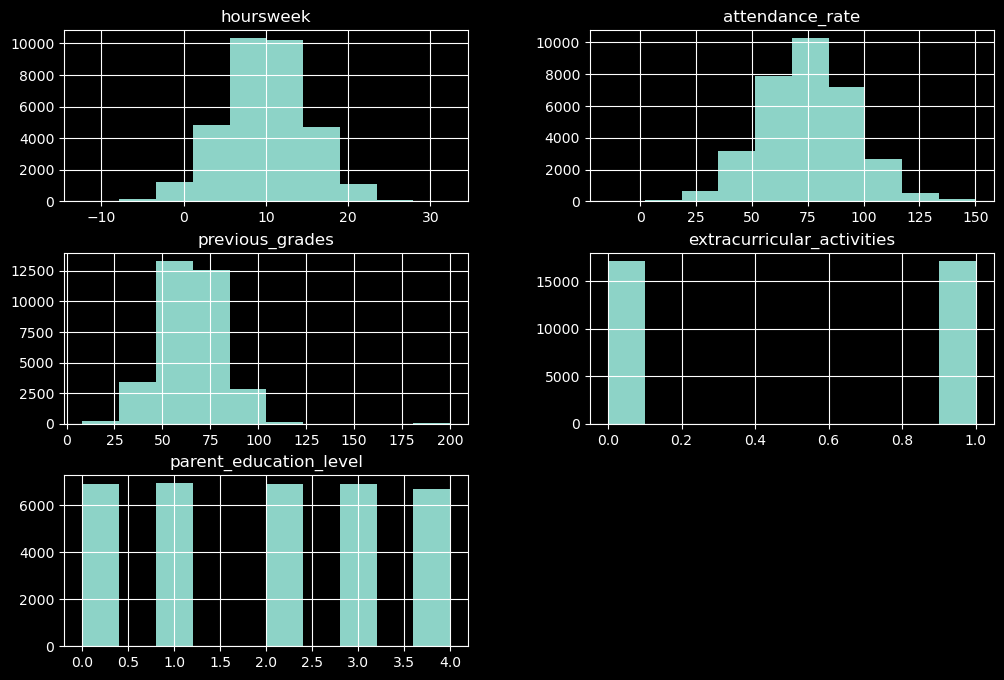

In [13]:
# строим гистограммы датасета
df_dropna[['hoursweek','attendance_rate','previous_grades','extracurricular_activities','parent_education_level']].hist(figsize=(12, 8));

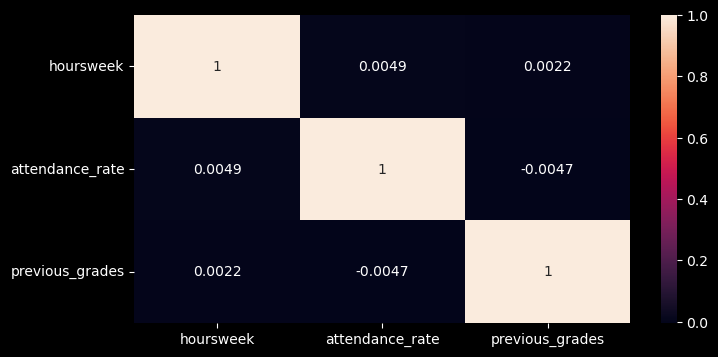

In [14]:
# строим матрицу корреляции
corr_matrix = df_dropna[['hoursweek','attendance_rate','previous_grades']].corr()

plt.figure(figsize=(8, 4))
sns.heatmap(data=corr_matrix, annot=True)
plt.show()

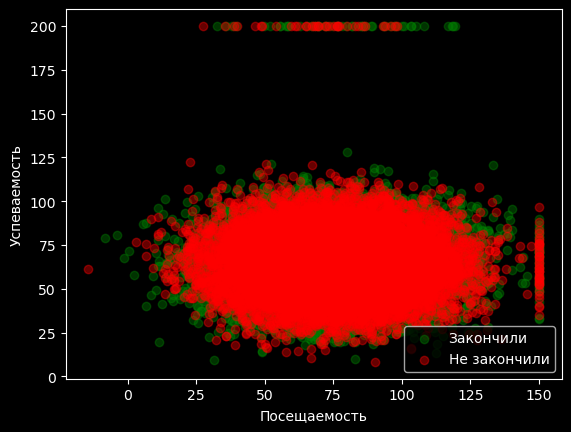

In [15]:
# разделение датасета на 2 части - те кто завершили обучение, и кто нет
df_0 = df_dropna[df_dropna.passed == 1]
df_1 = df_dropna[df_dropna.passed == 0]

# визуализация зависимости оценок от посещаемости с указанием успеха окончания обучения
plt.scatter(df_0.attendance_rate, df_0.previous_grades, color="green", label="Закончили", alpha=0.4)
plt.scatter(df_1.attendance_rate, df_1.previous_grades, color="red", label="Не закончили", alpha=0.4)
plt.xlabel(features_dict["attendance_rate"])
plt.ylabel(features_dict["previous_grades"])
plt.legend(loc='lower right')
plt.show()

На графике хорошо видны выбросы по previous_grades = 200 и attendance_rate = 150. Что скорее всего является ошибками сбора.

In [16]:
df_replace = df_dropna.copy()

In [17]:
# лямбда функция которая заменяет Nan медианой у столбца
replace_median = lambda col: col.fillna(col.mean())

# заменяем выбросы на NaN
replace_values_attendance_rate = df_replace[df_replace["attendance_rate"]>=150]["attendance_rate"].unique()

df_replace["previous_grades"] = df_replace["previous_grades"].replace(200, np.NaN)
df_replace["attendance_rate"] = df_replace["attendance_rate"].replace(replace_values_attendance_rate, np.NaN)

# заполняем NaN медианой
df_replace[df_replace.passed == 0] = df_replace[df_replace.passed == 0].apply(replace_median)
df_replace[df_replace.passed == 1] = df_replace[df_replace.passed == 1].apply(replace_median)

# удаляем записи у которых attendance_rate (посещаемость) ниже 0
df_replace = df_replace[df_replace['attendance_rate']>=0]

# нормализуем данные attendance_rate
ar_max = df_replace['attendance_rate'].max()
df_replace['attendance_rate'] = df_replace['attendance_rate'] / ar_max * 100 

# нормализуем данные previous_grades
pg_max = df_replace['previous_grades'].max()
df_replace['previous_grades'] = df_replace['previous_grades'] / pg_max * 100

# избавляемся от отрицательных значений в hoursweek
h_min = df_replace['hoursweek'].min()
df_replace['hoursweek'] = df_replace['hoursweek'] - h_min

In [18]:
print('Проверяем пропуски:\n')
print(df_replace.isna().sum())

Проверяем пропуски:

hoursweek                     0
attendance_rate               0
previous_grades               0
extracurricular_activities    0
parent_education_level        0
passed                        0
dtype: int64


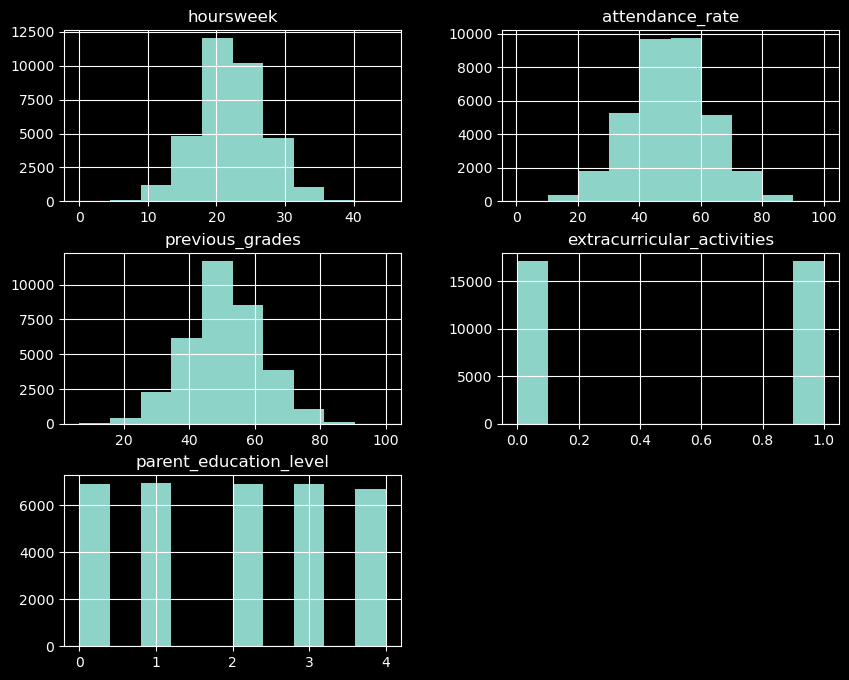

In [19]:
# строим итоговую гистограмму получившегося датасета
df_replace[['hoursweek','attendance_rate','previous_grades','extracurricular_activities','parent_education_level']].hist(figsize=(10, 8));

## Формирование X и Y

In [20]:
# предсказываем 0 или 1 - Закончит обучение или нет, X - все остальные признаки (задача классификации)
X = df_replace.drop(columns='passed').values
y = df_replace[['passed']].values

X.shape, y.shape

((34301, 5), (34301, 1))

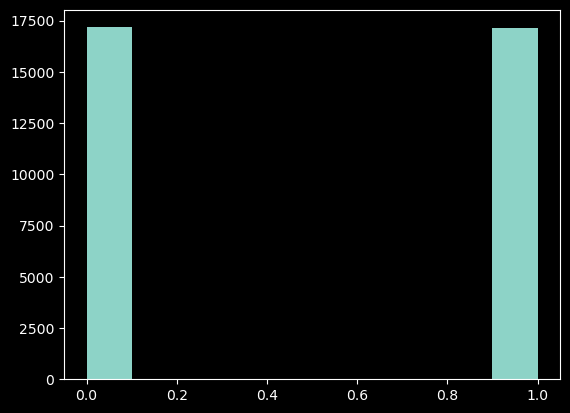

In [21]:
# распределение целевой переменной
plt.hist(y);

In [22]:
# разбиение на выборки для обучения и для тестирования модели
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24010, 5), (10291, 5), (24010, 1), (10291, 1))

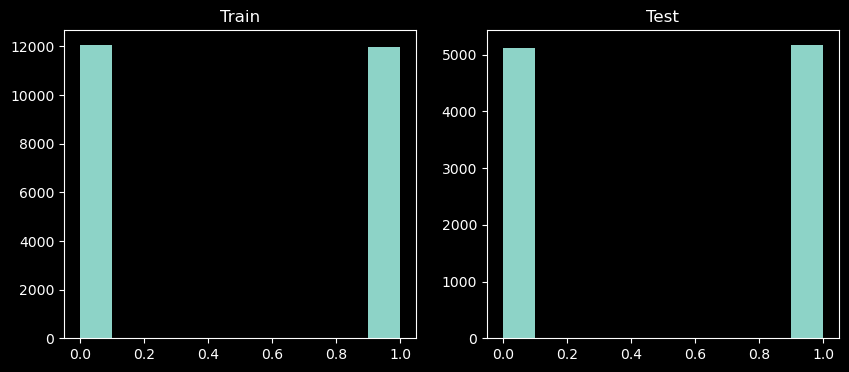

In [23]:
# посмотреть рапределение целевой переменной для y_train и y_test
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Train')
plt.hist(y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plt.hist(y_test)
plt.show()

## Обучение модели

In [24]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

def print_metrics(model, x, y):
    y_pred = model.predict(x)
    print(f'Accuracy: {accuracy_score(y, y_pred):.4f}')

    # balanced_accuracy_score вычисляет и усредняет accuracy отдельно по каждому классу - актуально при дисбалансе классов
    print(f'Balanced Accuracy: {balanced_accuracy_score(y, y_pred):.4f}')

    # параметр weighted - усреднение метрики с использованием весов, пропорциональных размеру каждого класса - актуально при дисбалансе классов
    print(f'F1 Score: {f1_score(y, y_pred, average="weighted"):.4f}')

In [25]:
# model = DecisionTreeClassifier(random_state=111)
# model.fit(X_train, y_train)
# print_metrics(model, X_test, y_test)

Accuracy: 0.5620
Balanced Accuracy: 0.5621
F1 Score: 0.5620


In [36]:
# параметры модели
model_params = dict(
    max_depth=100,        # макс глубина дерева
    min_samples_leaf=5,   # минимальное число объектов в листе
    min_samples_split=5,  # минимальное число объектов в разделении
    criterion='entropy',  # метрика для вычисления прироста информации
)

# инициализация модели
model = DecisionTreeClassifier(**model_params, random_state=111)
model.fit(X_train, y_train)
print_metrics(model, X_test, y_test)

Accuracy: 0.5755
Balanced Accuracy: 0.5755
F1 Score: 0.5753


In [27]:
# model = GradientBoostingClassifier()
# model.fit(X_train, y_train.ravel())
# print_metrics(model, X_test, y_test.ravel())

Accuracy: 0.5728
Balanced Accuracy: 0.5734
F1 Score: 0.5666


In [28]:
# model = KNeighborsClassifier()
# model.fit(X_train, y_train.ravel())
# print_metrics(model, X_test, y_test.ravel())

Accuracy: 0.5063
Balanced Accuracy: 0.5063
F1 Score: 0.5062


In [29]:
# model = LogisticRegression(max_iter=500)
# model.fit(X_train, y_train.ravel())
# print_metrics(model, X_test, y_test.ravel())

Accuracy: 0.4998
Balanced Accuracy: 0.5003
F1 Score: 0.4947


In [37]:
from sklearn.metrics import classification_report

# получить предсказания модели на тестовых данных
y_pred = model.predict(X_test)

# метрики считаются между реальными правильными ответами и предсказаниями модели
report = classification_report(y_test, y_pred, target_names=['Закончит', 'Не закончит'])
print(report)

              precision    recall  f1-score   support

    Закончит       0.57      0.59      0.58      5120
 Не закончит       0.58      0.56      0.57      5171

    accuracy                           0.58     10291
   macro avg       0.58      0.58      0.58     10291
weighted avg       0.58      0.58      0.58     10291



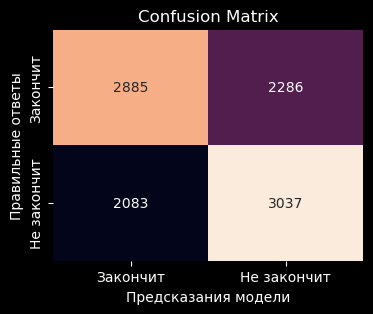

In [38]:
from sklearn.metrics import confusion_matrix

# предсказания модели на тестовых данных
y_pred = model.predict(X_test)

# создание confusion_matrix (в формате слева направо сверху вниз [TP, FN / FP, TN])
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

# отрисовка confusion_matrix
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt=".0f", cbar=False)
ax.set_xlabel('Предсказания модели')
ax.set_ylabel('Правильные ответы')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Закончит', 'Не закончит'])
ax.yaxis.set_ticklabels(['Закончит', 'Не закончит'])
plt.show()

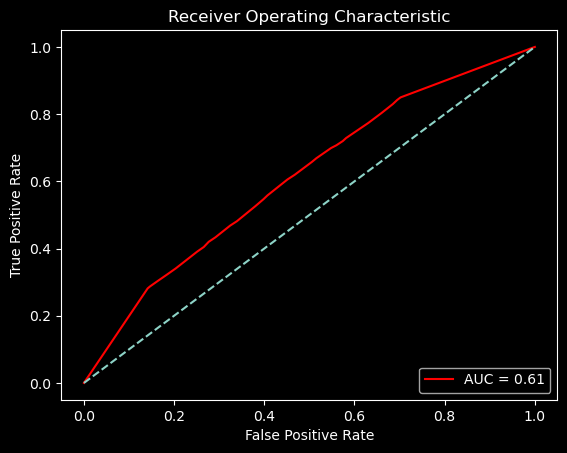

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# вероятности что есть диабет
y_probs = model.predict_proba(X_test)[:, -1]

# массивы TPR, FPR для каждого порога вероятностей
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probs)

# площадь под кривой
roc_auc = auc(false_positive_rate, true_positive_rate)

# отрисовка roc curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, color='red', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Сериализация модели

In [26]:
import pickle

# сохранить на диск в формате pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Инференс модели

In [ ]:
# так происходит загрузка сохраненной модели
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
# рандомные параметры для предсказания, данные которые пришли на вход
data = dict(
    hoursweek=14.3,
    attendance_rate=75.6,
    previous_grades=83.1,
    extracurricular_activities=0,
    parent_education_level=0
)
# создать датафрейм для отображения в приложении
data_df = pd.DataFrame([data])
data_df

In [ ]:
predict_proba = model.predict_proba(data_df.values)[0, 1]
predict_proba